In [1]:
import os
import csv
import cv2
import sys
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import xml.etree.ElementTree as ET

In [33]:
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D

c:\users\james\anaconda3\envs\nlp-asr\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

## Helper Functions

In [61]:
def get_filepaths(basepath, file_type=".xml"):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
        if filename.endswith(file_type):
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
        filenames.append(filename)
    return files, filenames
    
# TODO: Move above code into this function
def get_filepaths_videonum_dirs(basepath, file_type=".xml"):
    videonum_frame_filepaths = []
    videonum_frame_filenames = []
    # loop each video number dir getting each frame filepath per video
    for videonum_dir in os.listdir(basepath):
        videonum_dirpath = os.path.join(basepath, videonum_dir)
        videonum_dirfilepaths, videonum_dirfilenames = get_filepaths(videonum_dirpath, file_type)
        videonum_frame_filepaths.extend(videonum_dirfilepaths)
        videonum_frame_filenames.extend(videonum_dirfilenames)
    return videonum_frame_filepaths, videonum_frame_filenames
    
def read_img(img_path):
    # (height, width, 3)
    image = cv2.imread(img_path)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def create_image_batch(image_group):
    # get the max image shape from the batch of images
    max_shape = tuple()
    image_shapes = list()
    
    for channel in range(3):
        for image in image_group:
            image_shapes.append(image.shape[channel])
        
def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    
# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image


def plot_sample(X, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

## Load Training Images & Labels

## Get Polyp Names for Training Y Set

In [4]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [5]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths)

100%|███████████████████████████████████████████████████████████████████████████| 28773/28773 [01:59<00:00, 240.27it/s]


In [6]:
print(len(train_y_polyp_names))
print(train_y_polyp_names[0])
print(train_y_polyp_names[1])

28773
adenomatous
hyperplastic


In [14]:
train_y_polyp_names[:5]

['adenomatous', 'hyperplastic', 'adenomatous', 'hyperplastic', 'adenomatous']

c:\users\james\anaconda3\envs\nlp-asr\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


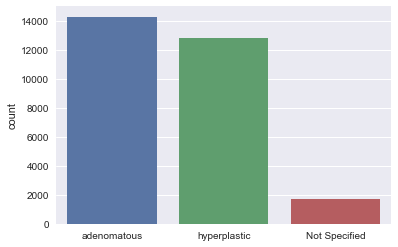

In [18]:
sns.countplot(train_y_polyp_names)

In [19]:
polyp_counter = collections.Counter(train_y_polyp_names)

In [20]:
polyp_counter

Counter({'Not Specified': 1725, 'adenomatous': 14269, 'hyperplastic': 12779})

In [15]:
label_enc = LabelEncoder()

In [25]:
# Label Encode y_train polyp names
train_y = label_enc.fit_transform(train_y_polyp_names)

In [26]:
train_y

array([1, 2, 1, ..., 1, 2, 1], dtype=int64)

In [21]:
classes = ['Not Specified', 'adenomatous', 'hyperplastic']

## Get Polyp Names for Validation Y Set

In [70]:
valid_y_basepath = "PolypsSet/val2019/Annotation"
file_type = ".xml"
    
valid_y_filepaths, valid_y_filenames = get_filepaths_videonum_dirs(valid_y_basepath, file_type=".xml")

In [41]:
os.listdir(valid_y_basepath)

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [71]:
valid_y_filepaths

['PolypsSet/val2019/Annotation\\1\\1.xml',
 'PolypsSet/val2019/Annotation\\1\\10.xml',
 'PolypsSet/val2019/Annotation\\1\\100.xml',
 'PolypsSet/val2019/Annotation\\1\\101.xml',
 'PolypsSet/val2019/Annotation\\1\\102.xml',
 'PolypsSet/val2019/Annotation\\1\\103.xml',
 'PolypsSet/val2019/Annotation\\1\\104.xml',
 'PolypsSet/val2019/Annotation\\1\\105.xml',
 'PolypsSet/val2019/Annotation\\1\\106.xml',
 'PolypsSet/val2019/Annotation\\1\\107.xml',
 'PolypsSet/val2019/Annotation\\1\\108.xml',
 'PolypsSet/val2019/Annotation\\1\\109.xml',
 'PolypsSet/val2019/Annotation\\1\\11.xml',
 'PolypsSet/val2019/Annotation\\1\\110.xml',
 'PolypsSet/val2019/Annotation\\1\\111.xml',
 'PolypsSet/val2019/Annotation\\1\\112.xml',
 'PolypsSet/val2019/Annotation\\1\\113.xml',
 'PolypsSet/val2019/Annotation\\1\\114.xml',
 'PolypsSet/val2019/Annotation\\1\\115.xml',
 'PolypsSet/val2019/Annotation\\1\\116.xml',
 'PolypsSet/val2019/Annotation\\1\\117.xml',
 'PolypsSet/val2019/Annotation\\1\\118.xml',
 'PolypsSet/va

In [72]:
valid_y_polyp_names = get_xml_label_names(valid_y_filepaths)

100%|█████████████████████████████████████████████████████████████████████████████| 4630/4630 [00:07<00:00, 613.03it/s]


In [73]:
# previous: 4630
print(len(valid_y_polyp_names))

4630


In [74]:
valid_y_polyp_names[:5]

['hyperplastic',
 'hyperplastic',
 'hyperplastic',
 'hyperplastic',
 'hyperplastic']

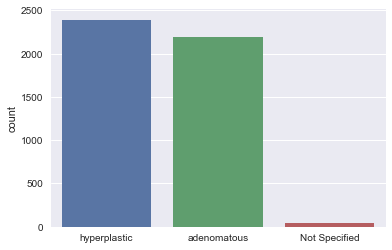

In [75]:
sns.countplot(valid_y_polyp_names)

In [76]:
valid_y = label_enc.fit_transform(valid_y_polyp_names)

In [77]:
valid_y

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

## Get Images for Training X Set

In [7]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [8]:
train_X_images = get_images(train_X_filepaths, 120)

100%|███████████████████████████████████████████████████████████████████████████| 28773/28773 [03:35<00:00, 133.43it/s]


In [10]:
X_train = np.array(train_X_images)

In [11]:
X_train.shape

(28773, 120, 120, 3)

In [12]:
X_train[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

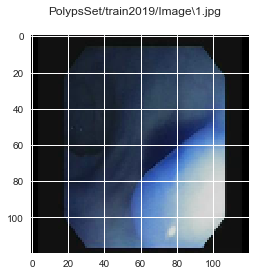

In [13]:
plt.suptitle(train_X_filepaths[0])
plt.imshow(X_train[0])

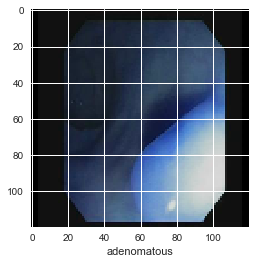

In [29]:
plot_sample(X_train, y_train, 0)

In [30]:
# divide by 255, normalize img between 0 and 1 range
X_train[0]/255

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [31]:
# So now we can apply normalize to each img in X_train & X_test
X_train = X_train / 255

## Get Images for Validation X Set

In [80]:
valid_X_basepath = "PolypsSet/val2019/Image"
file_type = ".jpg"
valid_X_filepaths, valid_X_filenames = get_filepaths_videonum_dirs(valid_X_basepath, file_type)

# train_X_basepath = "PolypsSet/train2019/Image"
# file_type = ".jpg"
# train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [81]:
os.listdir(valid_X_basepath)

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [ ]:
valid_X_images = get_images(valid_X_filepaths, 120)

In [ ]:
X_valid = np.array(valid_X_images)

In [ ]:
X_valid.shape

In [ ]:
plot_sample(X_valid, y_valid, 0)

In [ ]:
# So now we can apply normalize to each img in X_train & X_test
X_valid = X_valid / 255

## Build Artificial Neural Network

In [34]:
ann = models.Sequential([
    # flatten layer 2D 32x32 RGB img to array vector
    layers.Flatten(input_shape=(120,120,3)),
    # Deep dense layer with 3000 neurons and relu activation
    layers.Dense(3000, activation="relu"),
    # Deep dense layer with 1000 neurons and relu activation
    layers.Dense(1000, activation="relu"),
    # Last dense layers has 3 neurons since we have 10 categories
    layers.Dense(3, activation="sigmoid")
])

In [35]:
# we are using sparse_categorical_crossentropy since our y_train is 
# label encoded
ann.compile(optimizer="SGD",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

In [36]:
ann.fit(X_train, y_train, epochs=5)

Epoch 1/5
28773/28773 [==============================] - 132s 5ms/step - loss: 0.6457 - acc: 0.7010
Epoch 2/5
28773/28773 [==============================] - 81s 3ms/step - loss: 0.3655 - acc: 0.8649: 1s - loss: 0.3625 - acc: 0.86 - ETA: 1s - loss: 
Epoch 3/5
28773/28773 [==============================] - 81s 3ms/step - loss: 0.2443 - acc: 0.9131
Epoch 4/5
28773/28773 [==============================] - 55s 2ms/step - loss: 0.1897 - acc: 0.9336
Epoch 5/5
28773/28773 [==============================] - 48s 2ms/step - loss: 0.1461 - acc: 0.9483
